# AM216 Mini-Project: Drug target interaction and COVID-19

Rapid determination of whether a candidate small molecule will bind to a particular target receptor protein remains a stumbling block in drug discovery.  If you can find a small molecule that binds to a relevant protein and modifies its function, this molecule can serve as a drug.   This is an **inverse problem**: Given a protein, please find a small molecule that can bind to it.  

One way of solving this inverse problem would be to use molecular dynamics: Create a molecular model of a protein. Create a molecular model of all possible small molecule drugs that can bind to the protein. Simulate the interactions between the small molecules and the proteins. Find the molecules that work.

Or-you might be more mathematical and try to solve this as a straight-up optimization problem: Find the small molecule that optimally binds to the binding pocket of a given drug.

Although conceptually appealing, this methodology is impossible: The major bottleneck is that we do not know and cannot accurately represent the interactions between small molecules and proteins.  The potentials are empirical with fitting parameters--they cannot be found from first principles and despite decades of work, we simply do not have good representations for them. For that reason, physical computation has been of limited utility for drug discovery.  

We should mention that a secondary bottleneck is the computing power that would be required for this search -- but this is something that could be likely sorted out if it weren't for the first bottleneck.

An alternative approach is to use a *data driven approach*. Instead of representing the physics, lets make a list of all known proteins and all small molecules that binds to each protein.  Lets then design a data driven way of associating small molecules to proteins, representing binding.  

Note that for a data driven approach to succeed, the key step is to **find ways of representing the small molecule and the protein that make it possible to find the patterns in the existing datasets.**   Representation is the key problem.  Presumably, the best way to represent the proteins and the small molecules is to use the physics and biochemistry of what happens when binding occurs -- as by doing this, we will focus on features that are relevant.  Finding the right feature representations for this type of problem is a very active area of research.

In this miniproject, you will dip your toe into the pond by studying a canonical problem, the binding affinity of small molecules against target proteins.  

Given all that is happening in the world right now, it seems appropriate to assign you the additional mission is to use the trained model to identify drugs that could bind to the main protease$^*$ protein of COVID-19 and prevent the production of viral enzyme. 

To help you in this mission, you are given KIBA ("Kinase Inhibitor Bioassay") dataset which contains 2111 drugs and 229 proteins with total of 118254 drug-protein binding affinity scores. Those are stored in `ligands_can.txt`, `proteins.txt`, and `Y`, respectively. The rows of `Y` index drugs and the columns index proteins. The element of `Y` is a real-valued binding score that takes into account dissociation constant $K_d$, inhibition constant $K_i$, and half maximal inhibitory concentration $IC_{50}$. Refer to [original paper](https://pubs.acs.org/doi/pdf/10.1021/ci400709d) for more detail. We also provide splitted indices for 5-fold cross validation in `train_fold_setting.txt` and testset indices in `test_fold_setting.txt`. Lastly, `6Y84_A.fasta.txt` contains the amino acid sequence of COVID-19 protease.

You will evalulate the performance of your model using MSE and Corcordance Index (CI), which is slightly relaxed metric that measures whether the predicted binding affinity val- ues of two random drug–target pairs were predicted in the same order as their true values were.

*: Note that there are many other drug targets for COVID-19 virus. [This page](
https://www.guidetopharmacology.org/coronavirus.jsp) gives you a good summary. 

To help you get started, we will first introduce you to Rdkit and DeepChem packages.

## 1. Basic Cheminformatics with Rdkit and DeepChem

For this project, you will most likely heavily rely on Rdkit and Deepchem. You can install DeepChem along with Rdkit following instruction [here](https://deepchem.io). If you are using Colab, run the following code block.


In [3]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [4]:
# This may take a few minutes to run!
!wget -c https://repo.anaconda.com/archive/Anaconda3-2019.10-Linux-x86_64.sh
!chmod +x Anaconda3-2019.10-Linux-x86_64.sh
!bash ./Anaconda3-2019.10-Linux-x86_64.sh -b -f -p /usr/local
!conda install -y -c deepchem -c rdkit -c conda-forge -c omnia deepchem-gpu=2.3.0
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')
import deepchem as dc

--2021-04-15 19:48:54--  https://repo.anaconda.com/archive/Anaconda3-2019.10-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 530308481 (506M) [application/x-sh]
Saving to: ‘Anaconda3-2019.10-Linux-x86_64.sh’

Anaconda3-2019.10-L 100%[===================>] 505.74M   163MB/s    in 3.1s    

2021-04-15 19:48:58 (163 MB/s) - ‘Anaconda3-2019.10-Linux-x86_64.sh’ saved [530308481/530308481]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: | / - \ | / - \ | / - \ | / - \ | / - done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _ipyw_jlab_nb_ext_conf==0.1.0=py37_0
    - _libgcc_mutex==0.1=main
    - alabaster==0.7.12=py37_0
    - anaconda-client==1.7.2=py37_0
    - anaconda-navigator==1.9.7=py37

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Developing new medicine is a very time-consuming, labor-intensive, and expensive task which begins with rounds of screening process where researchers run some assays with thousands of molecules to identify potential drug candidates to go onto a clinical trial. The field of cheminformatics have been developed to help accelerate this process by performing laboratory experiments on computers. 

In order to this we need to find a way to represent a molecule so that we can train machine learning models on it.  As mentioned above, this is a critical step.   If we were doing physics we would want to represent the molecule in the most natural way to represent the physics. For example there are features of the molecules that *cause* it to bind to the protein in question -- there are specific interactions between the chemical groups of the molecule and the amino acids. From a physical perspective, identifying these features is the most important part of the problem and we would like the representation to emphasize these.

But given that we don't have any idea what is happening, we need another approach. We somehow have to represent both molecules and proteins in a way so that we can train machine learning models on them to see if it is possible to associate them with each other.

For small molecules, this is a classic problem. How do we take a molecule and represent it. There is a field that has addressed this called 'cheminformatics'.  

A particularly simple method is for molecules are represented as text strings called SMILES (“Simplified Molecular-Input Line-Entry System”). Please refer to [this page](https://www.daylight.com/dayhtml/doc/theory/theory.smiles.html) for more explanantion. Here is an example SMILES string and the molecule it represents, which we obtain via `MolFromSmiles` function of Rdkit.

In [2]:
from google.colab import drive
drive.mount('/content/drive')
G_PATH = './drive/MyDrive/AM216/Drug Binding/'

Mounted at /content/drive


In [ ]:
# %%capture
# !unzip data_Drug_target_binding_affinity.zip

In [5]:
import numpy as np
import rdkit
from rdkit.Chem import Draw
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import MolFromSmiles

SMILES string:
O[C@@H](CNC1CCN(CC1)c2ccc(CC3SC(=O)NC3=O)cc2)c4ccc(O)c(NS(=O)(=O)c5ccccc5)c4

Original molecule:


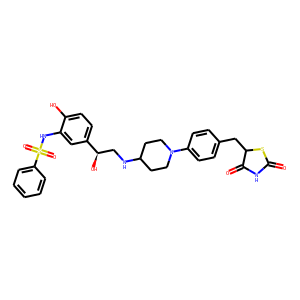

In [6]:
smiles = []
with open(G_PATH + 'data_Drug_target_binding_affinity/Sample_Ligand_List.txt', 'r') as f:
    for line in f:
        smiles.append(line[:-1])
        
print('SMILES string:')
print(smiles[0])

print('\nOriginal molecule:')
mols = MolFromSmiles(smiles[0])
Draw.MolToImage(mols)

As you may have guessed, this SMILES string does not contain much of structural and chemical information present in the actual molecule representation. 

The smiles string is a string of symbols -- it is very different from the binding structure of the molecules.  One option that we have is to train machine learning models on the smiles strings directly.

This has been found to not be the most effective way of proceeding. Another approach that people have thought of is to convert this to a "chemical fingerprint". This is a
 vector of 1's and 0's that captures the presence or absence of specific features, as determined by local arrangement of atoms in a molecule.  


There are many algorithms that give you this finger print. One example is Extended-connectivity fingerprints (ECFP) scheme, which comes as `GetMorganFingerprintAsBitVec` in Rdkit. Here is an example of ECFP4. The number at the end refers to bond distances used for featurizing.

In [7]:
print('ECFP4')
molecule = MolFromSmiles(smiles[0])
ECFP2 = Chem.GetMorganFingerprintAsBitVect(molecule, 2).ToBitString()
ECFP2arr = np.array(list(map(int, ECFP2)))
print(ECFP2arr[:20], '...')
print(ECFP2arr.shape)

ECFP4
[0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] ...
(2048,)


Lots of Rdkit's featurization algorithms are ported in DeepChem. This is a deep learning for chemistry toolkit that was developed at Stanford.

We can list the descriptors for molecules from RDKIT. Note that in addition to fingerprints, there are all sorts of purely chemical features, such as


*   Number of Hydrogen acceptors
*   Number of aromatic rings
*   Number of radical electrons
*   Number of rings in the molecule
*   Partial charges


And so forth.  When you are doing machine learning with complete ignorance of why the small molecule binds to something, you might as well be as general as you can be!!



In [8]:
from deepchem.feat import RDKitDescriptors   

for descriptor in RDKitDescriptors.allowedDescriptors:
    print(descriptor)


NOCount
Chi1
NumAromaticCarbocycles
EState_VSA9
VSA_EState5
EState_VSA7
NumSaturatedRings
HeavyAtomMolWt
Chi2n
NumHeteroatoms
PEOE_VSA4
Chi2v
EState_VSA5
Chi4v
NumValenceElectrons
Kappa2
EState_VSA4
HeavyAtomCount
NumSaturatedCarbocycles
Ipc
MaxPartialCharge
PEOE_VSA8
SlogP_VSA7
PEOE_VSA11
SMR_VSA3
SMR_VSA2
VSA_EState3
NHOHCount
PEOE_VSA1
Chi0
VSA_EState1
SlogP_VSA12
SlogP_VSA2
Chi1v
SMR_VSA10
FractionCSP3
VSA_EState7
MinAbsPartialCharge
SMR_VSA8
MolLogP
PEOE_VSA9
SMR_VSA5
EState_VSA11
EState_VSA2
PEOE_VSA6
ExactMolWt
BertzCT
RingCount
PEOE_VSA14
Chi1n
PEOE_VSA5
LabuteASA
NumHAcceptors
SlogP_VSA4
MinPartialCharge
Chi0n
SMR_VSA7
TPSA
EState_VSA1
NumAliphaticRings
SlogP_VSA6
NumRotatableBonds
NumAromaticRings
PEOE_VSA7
EState_VSA8
MinAbsEStateIndex
Kappa1
BalabanJ
SlogP_VSA11
HallKierAlpha
SMR_VSA1
SlogP_VSA1
NumAliphaticHeterocycles
Chi3v
VSA_EState8
SlogP_VSA3
PEOE_VSA2
VSA_EState9
MolMR
PEOE_VSA13
EState_VSA3
MaxAbsPartialCharge
Chi4n
SMR_VSA6
Kappa3
VSA_EState4
NumAliphaticCarbocycle

Deepchem has also implemented a large number of different machine learning models to build models on top of these features. We can list this as follows:

In [9]:
dir(dc.models)

['ANIRegression',
 'AtomicConvModel',
 'BPSymmetryFunctionRegression',
 'ChemCeption',
 'DAGModel',
 'DAGTensorGraph',
 'DTNNModel',
 'DTNNTensorGraph',
 'GAN',
 'GraphConvModel',
 'GraphConvTensorGraph',
 'IRV',
 'KerasModel',
 'MPNNModel',
 'MPNNTensorGraph',
 'Model',
 'MultitaskClassifier',
 'MultitaskFitTransformRegressor',
 'MultitaskRegressor',
 'OntologyModel',
 'OntologyNode',
 'ProgressiveMultitaskClassifier',
 'ProgressiveMultitaskRegressor',
 'RobustMultitaskClassifier',
 'RobustMultitaskRegressor',
 'ScScoreModel',
 'SeqToSeq',
 'SequenceDNN',
 'Sequential',
 'SingletaskToMultitask',
 'SklearnModel',
 'Smiles2Vec',
 'TensorGraph',
 'TensorflowMultitaskIRVClassifier',
 'TextCNNModel',
 'TextCNNTensorGraph',
 'ValidationCallback',
 'WGAN',
 'WeaveModel',
 'WeaveTensorGraph',
 'XGBoostModel',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'atomic_conv',
 'callbacks',
 'chemnet_models',
 'create_g

## 2. Parsing KIBA dataset

Now we are ready to examine the Kinase dataset.  The way this works is that we are given a particular protein, and for that protein, we want to predict the small molecules that bind to it. Different proteins of course have different sets of small molecules.  This dataset contains a large set of proteins, and for each of them, it contains the small molecules that bind.

To associate proteins with small molecules, we also need a representation of the proteins. Proteins are of course sequences of amino acids, so the representation is just a string of amino acids.   To use the string of amino acids with numbers. We do this by simply mapping each amino acid (represented by a letter) to a number.

In [10]:
import matplotlib.pyplot as plt
import json
import pickle
from collections import OrderedDict
import networkx as nx

In [11]:
# for converting protein sequence to categorical format
seq_voc = "ABCDEFGHIKLMNOPQRSTUVWXYZ"
seq_dict = {v:i for i,v in enumerate(seq_voc)}
seq_dict_len = len(seq_dict)
max_seq_len = 1000   # Note that all protein data will have the same length 1000 

def seq_to_cat(prot):
    x = np.zeros(max_seq_len)
    for i, ch in enumerate(prot[:max_seq_len]): 
        x[i] = seq_dict[ch]
    return x  

# for Concordance index evaluation
def ci(y,f):
    ind = np.argsort(y)
    y = y[ind]
    f = f[ind]
    i = len(y)-1
    j = i-1
    z = 0.0
    S = 0.0
    while i > 0:
        while j >= 0:
            if y[i] > y[j]:
                z = z+1
                u = f[i] - f[j]
                if u > 0:
                    S = S + 1
                elif u == 0:
                    S = S + 0.5
            j = j - 1
        i = i - 1
        j = i - 1
    ci = S/z
    return ci if z != 0 else 0

We read in the ligands and the proteins, as well as the binding data.

In [12]:
fpath = G_PATH + 'data_Drug_target_binding_affinity/data/kiba/'

# Read in drugs and proteins
drugs_ = json.load(open(fpath + "ligands_can.txt"), object_pairs_hook=OrderedDict)
drugs = np.array([Chem.MolToSmiles(Chem.MolFromSmiles(d),isomericSmiles=True) for d in drugs_.values()])
proteins_ = json.load(open(fpath + "proteins.txt"), object_pairs_hook=OrderedDict)
proteins = np.array(list(proteins_.values()))

# Read in affinity data
affinity = np.array(pickle.load(open(fpath + "Y","rb"), encoding='latin1'))

# Read in train/test fold  
train_fold = json.load(open(fpath + "folds/train_fold_setting1.txt"))
train_fold = [ee for e in train_fold for ee in e ]    
'''
Here all validation folds are aggregated into training set. 
If you want to train models with different architectures and/or 
optimize for model hyperparameters, we encourage you to use 5-fold 
cross validation as provided here.
'''
test_fold = json.load(open(fpath + "folds/test_fold_setting1.txt"))

# Prepare train/test data with fold indices
rows, cols = np.where(np.isnan(affinity)==False) 
drugs_tr = drugs[rows[train_fold]]    # (98545,)
proteins_tr = np.array([seq_to_cat(p) for p in proteins[cols[train_fold]]])   # (98545, 1000)
affinity_tr = affinity[rows[train_fold], cols[train_fold]]  # (98545,)

drugs_ts = drugs[rows[test_fold]] # (19709,)
proteins_ts = np.array([seq_to_cat(p) for p in proteins[cols[test_fold]]]) # (19709, 1000)
affinity_ts = affinity[rows[test_fold], cols[test_fold]]    # (19709,)

In [13]:
print('Example of drug:{}'.format(drugs_tr[0]))
print('Example of protein:{} ...'.format(proteins_tr[0][:10]))
print('Example of affinity score:{}'.format(affinity_tr[0]))

Example of drug:O=C1c2c(c3c4ccc(O)cc4n(C4OC(CO)C(O)C(O)C4O)c3c3[nH]c4cc(O)ccc4c23)C(=O)N1NC(CO)CO
Example of protein:[11. 17.  0. 12. 12. 17. 14. 14. 17.  0.] ...
Example of affinity score:9.798970004000001


In [33]:
# Convert to ECFP fingerprint
smileToMol = lambda x: MolFromSmiles(x)
featurizer = dc.feat.CircularFingerprint(size=1024)

drugs_mol_tr = list(map(smileToMol, drugs_tr))
drugs_ecfp_tr = featurizer.featurize(drugs_mol_tr)
drugs_mol_ts = list(map(smileToMol, drugs_ts))
drugs_ecfp_ts = featurizer.featurize(drugs_mol_ts)

print(drugs_ecfp_tr.shape)
print(drugs_ecfp_ts.shape)

(98545, 1024)
(19709, 1024)


In [132]:
tr_size, drug_size = drugs_ecfp_tr.shape[0], drugs_ecfp_tr.shape[1]
ts_size = drugs_ecfp_ts.shape[0]

protein_size = max_seq_len

## 3. Train a model on KIBA data

In [133]:
# Have fun!
import tensorflow as tf
from keras import Sequential, Model
from keras.layers import Dense, concatenate, Dropout

def build_baseline_model(drug_size, protein_size):

  drug_model = Sequential()
  drug_model.add(Dense(1, input_shape=(drug_size,), activation='linear'))

  protein_model = Sequential()
  protein_model.add(Dense(1, input_shape=(protein_size,), activation='linear'))

  # concat_layer = tf.keras.layers.Concatenate([drug_model.outputs[0], protein_model.outputs[0]])
  model_concat = concatenate([drug_model.output, protein_model.output])
  # fully connected
  model_concat = Dense(1024, activation='relu')(model_concat)
  model_concat = Dropout(0.1)(model_concat)
  model_concat = Dense(1024, activation='relu')(model_concat)
  model_concat = Dropout(0.1)(model_concat)
  model_concat = Dense(512, activation='relu')(model_concat)
  model_concat = Dense(1, kernel_initializer='normal')(model_concat)
  
  model = Model(inputs=[drug_model.input, protein_model.input], outputs=model_concat)

  model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
  
  return model

model = build_baseline_model(drug_size=drug_size, protein_size=protein_size)
print(model.summary())

Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dense_113_input (InputLayer)    (None, 1024)         0                                            
__________________________________________________________________________________________________
dense_114_input (InputLayer)    (None, 1000)         0                                            
__________________________________________________________________________________________________
dense_113 (Dense)               (None, 1)            1025        dense_113_input[0][0]            
__________________________________________________________________________________________________
dense_114 (Dense)               (None, 1)            1001        dense_114_input[0][0]            
___________________________________________________________________________________________

In [135]:
from keras.callbacks import EarlyStopping

epochs = 100
batch_size = 50

callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

train_history = model.fit([drugs_ecfp_tr, proteins_tr], affinity_tr, 
                    validation_split=0.2, batch_size=batch_size, epochs=epochs, verbose=True)


Train on 78836 samples, validate on 19709 samples
Epoch 1/100
78836/78836 [==============================] - 68s 865us/step - loss: 0.5321 - mean_squared_error: 0.5321 - val_loss: 2.0868 - val_mean_squared_error: 2.0868
Epoch 2/100
78836/78836 [==============================] - 69s 873us/step - loss: 0.5283 - mean_squared_error: 0.5283 - val_loss: 2.1565 - val_mean_squared_error: 2.1565
Epoch 3/100
78836/78836 [==============================] - 67s 853us/step - loss: 0.5310 - mean_squared_error: 0.5310 - val_loss: 1.2997 - val_mean_squared_error: 1.2997
Epoch 4/100
78836/78836 [==============================] - 66s 838us/step - loss: 0.5190 - mean_squared_error: 0.5190 - val_loss: 1.6997 - val_mean_squared_error: 1.6997
Epoch 5/100
78836/78836 [==============================] - 67s 844us/step - loss: 0.5052 - mean_squared_error: 0.5052 - val_loss: 1.7902 - val_mean_squared_error: 1.7902
Epoch 6/100
78836/78836 [==============================] - 67s 855us/step - loss: 0.5030 - mean_squa

KeyboardInterrupt: ignored

In [137]:
# save the trained model
import os
save_folder = f'{G_PATH}/saved_models/'
os.makedirs(save_folder, exist_ok=True)
save_path = save_folder + 'baseline_model'
model.save(save_path)

# load model
# model = keras.models.load_model(save_path)

In [147]:
# summarize history for loss
# print(history.history.keys())
# plt.plot(train_history.history['loss'])
# plt.plot(train_history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

print("Evaluate on test data")
results = model.evaluate([drugs_ecfp_ts, proteins_ts], affinity_ts, batch_size=128)
print("test MSE loss is:", results)

Evaluate on test data
19709/19709 [==============================] - 2s 105us/step
test MSE loss is: [0.398003730737514, 0.3980037271976471]


In [143]:
predicted_affinity = model.predict([drugs_ecfp_ts, proteins_ts])

In [161]:
ci_score = ci(affinity_ts, predicted_affinity)
print('test CI score is:', ci_score)

test CI score is: 0.7536044611424282


[The original paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4364066/) obtained CI score of 0.782 and MSE of 0.411, and [random forest model](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5395521/) got 0.836 and 0.222. Can you beat them?

## 4. Use  your model on COVID-19 protease

Now, use your trained model to identify drugs that could be used as COVID-19 protease inhibitors from these 2111 drugs in the dataset. The sequence of the protease is provided in `6Y84_A.fasta.txt`. You might want to first predict a binding affinity of Ritonavior, a well known HIV drug that binds to HIV protease, to get the sense of a good binding score for this task. SMILES of Ritonavior is provided below.  

In [ ]:
ritonavior = 'CC(C)C1=NC(=CS1)CN(C)C(=O)NC(C(C)C)C(=O)NC(CC2=CC=CC=C2)CC(C(CC3=CC=CC=C3)NC(=O)OCC4=CN=CS4)O'
rit_mol = MolFromSmiles(ritonavior)
Draw.MolToImage(rit_mol)

Please keep in mind that proteins in KIBA data are kinase family, a different kind from protease. So in this exercise, we are relying on transfer learning. That is, the learned embedding for predicting kinase could be useful for predicting protease binding as well.